클러스터링은 거리 기반으로는 타겟의 분배를 잘 함.  
여기서 타겟 개수 제한의 경우 문제가 생기는데..  
학습 단계에서 처리할 방법은 쉽게 보이지 않음.  
학습이 완료되고 개수가 지나치게 이상한 경우 추가적인 알고리즘을 사용하여 개수를 적당히 분배할 것.  
여기에서 무게는 일단 배제한다.   


In [46]:
import torch
from torch import multiprocessing
import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append('/home/ksh-server/workspace/ICUFN')
from my_clustering.my_vmas.scenarios.navigation_clustering import Scenario

In [47]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device

env = Scenario()
world = env.make_world(
        device=device,
        n_agents=4,
        batch_dim=1
    )


In [48]:
def world_reset(env):
    env.reset_world_at()
    agents = env.world.agents
    targets = env.targets
    finished_position = env.finished_targets

    return agents, targets, finished_position

In [49]:
def initial_render(agents, targets, finished_position):
    map_size = 2

    # 플롯 생성
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(-map_size, map_size)
    ax.set_ylim(-map_size, map_size)
    ax.set_title("Agent and Target Distribution")

    # 에이전트 플로팅 (파란색 원)
    for i, agent in enumerate(agents):
        x, y = agent.state.pos.squeeze().tolist()
        ax.add_patch(plt.Circle((x, y), agent.shape.radius, color=agent.color, alpha=1, label=f"Agent_{i+1}"))

    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        label = "target" if targets[0] == target else None
        ax.add_patch(plt.Circle((x, y), target.shape.radius, color="black", alpha=1, label=label))
        
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        label = 'finished_position' if finished_position[0] == pos else None
        ax.add_patch(plt.Circle((x, y), targets[0].shape.radius, color='gray', alpha=1, label=label))

    # 범례 및 표시
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

In [50]:
# def numpy_pos(agents, targets, finished_position):
#     agents_pos = []
#     for agent in agents:
#         x, y = agent.state.pos.squeeze().tolist()
#         agents_pos.append([x, y])
#     agents_pos = np.array(agents_pos)
    
#     targets_pos = []
#     targets_cost = []
#     for target in targets:
#         x, y = target.state.pos.squeeze().tolist()
#         targets_pos.append([x, y])
#         cost = target.cost.item()
#         targets_cost.append(cost)
#     targets_pos = np.array(targets_pos)
#     targets_cost = np.array(targets_cost)

#     finished_pos = []
#     for pos in finished_position:
#         x, y = pos[0].squeeze().tolist()
#         finished_pos.append([x, y])
#     finished_pos = np.array(finished_pos)
    
#     return agents_pos, targets_pos, targets_cost, finished_pos

In [51]:
def numpy_pos(agents, targets, finished_position):
    agents_pos = []
    for agent in agents:
        x, y = agent.state.pos.squeeze().tolist()
        agents_pos.append([x, y])
    agents_pos = np.array(agents_pos)
    
    targets_pos = []
    targets_cost = []
    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        targets_pos.append([x, y])
        cost = target.cost.item()
        targets_cost.append(cost)
    targets_pos = np.array(targets_pos)
    targets_cost = np.array(targets_cost)

    finished_pos = []
    for pos in finished_position:
        x, y = pos.state.pos.squeeze().tolist()
        finished_pos.append([x, y])
    finished_pos = np.array(finished_pos)
    
    return agents_pos, targets_pos, targets_cost, finished_pos

In [52]:
agents, targets, finished_position= world_reset(env)

In [53]:
agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)


In [54]:
from sklearn.cluster import KMeans
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

In [55]:
# agents_pos
# targets_pos, targets_cost
# finished_pos

In [56]:
n_clusters = len(agents)

In [57]:
def kmeans_clust(targets_pos):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [58]:
def kmeans_cost_division_clust(targets_pos, targets_cost):
    # 타겟 증식
    for i, cost in enumerate(targets_cost):
        count = cost // 10 - 1
        for _ in range(count):
            targets_pos = np.concatenate((targets_pos, np.expand_dims(targets_pos[i], axis=0)), axis=0)
            
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, targets_pos

In [59]:
def zip_clusters(agents, targets, labels):
    clusters = [[] for _ in range(len(agents))]
    for target, label in zip(targets, labels):
        clusters[label].append(target)
    return clusters

In [60]:
def clusters_render(agents, clusters, centers, func= lambda target : target.state.pos.squeeze().tolist()):
    plt.Figure(figsize=(4, 4))
    for i, cluster in enumerate(clusters):
        for j, target in enumerate(cluster):
            x, y = func(target)
            plt.scatter(x, y, color = agents[i].color, label = f"agent{i+1}" if j == 0 else "")
            
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='*', alpha=0.2, s=200, label='Centers')
    plt.title("Target Position Clustering")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    plt.grid(True)
    plt.axis('equal')
    plt.show()

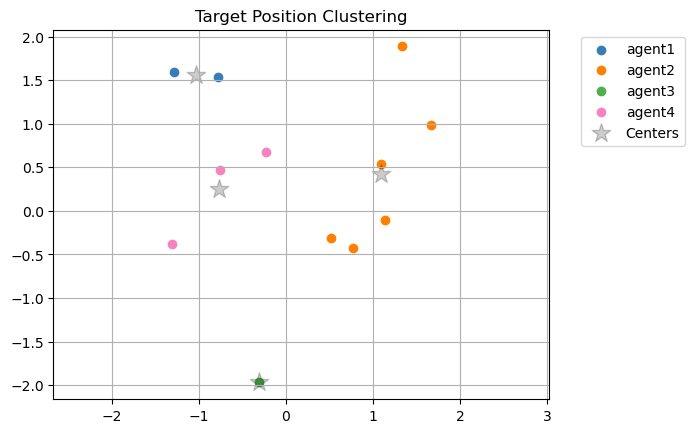

[[<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>], [<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>], [<vmas.simulator.core.Landmark object at 0x76bca841f1f0>], [<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>]]


In [61]:
labels, centers = kmeans_clust(targets_pos)
clusters = zip_clusters(agents, targets, labels)
clusters_render(agents, clusters, centers)
print(clusters)

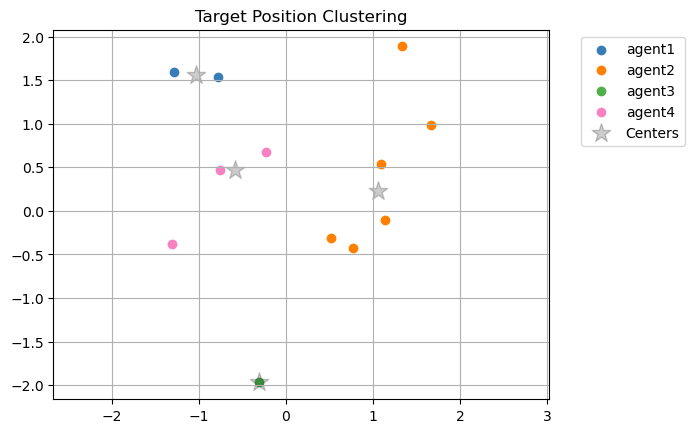

20
60
10
30


In [62]:
labels, centers, expended = kmeans_cost_division_clust(targets_pos, targets_cost)
clusters = zip_clusters(agents, targets, labels)
clusters_render(agents, clusters, centers)

# 분배된 코스트
for cluster in clusters:
    print(len(cluster)*10)

In [63]:
# 센터와 드론 위치 비교해서 위치 변경해줘야 함.

In [64]:
from scipy.optimize import linear_sum_assignment

def closest_centers(agents_pos, centers, clusters):
    # 거리 행렬 계산 (agents x centers)
    cost_matrix = np.linalg.norm(agents_pos[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)

    # 헝가리 알고리즘으로 최소 거리 매칭
    agent_indices, center_indices = linear_sum_assignment(cost_matrix)
    
    closest_clusters = [clusters[i] for i in center_indices]
    
    return agent_indices, center_indices, closest_clusters

In [65]:
agent_indices, center_indices, closest_clusters = closest_centers(agents_pos, centers, clusters)

print("에이전트별 가장 가까운 센터 인덱스 (중복 없음):")
for agent_idx, center_idx in zip(agent_indices, center_indices):
    print(f"Agent {agent_idx} → Center {center_idx}")
    print(closest_clusters[agent_idx])
print(center_indices)

# 필요한 건 closest_clusters

에이전트별 가장 가까운 센터 인덱스 (중복 없음):
Agent 0 → Center 2
Agent 1 → Center 0
[<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>]
Agent 2 → Center 3
[<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>]
Agent 3 → Center 1
[<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>]
[2 0 3 1]


In [66]:
def figure_closest_centers(agents_pos, centers, agent_indices, center_indices):
    plt.figure(figsize=(8, 6))

    # 에이전트 (파란 점)
    plt.scatter(agents_pos[:, 0], agents_pos[:, 1], c='blue', label='Agents', s=100)

    # 센터 (빨간 X)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', label='Centers', s=100, marker='X')

    # 에이전트와 센터를 점선으로 연결
    for agent_idx, center_idx in zip(agent_indices, center_indices):
        agent = agents_pos[agent_idx]
        center = centers[center_idx]
        plt.plot([agent[0], center[0]], [agent[1], center[1]], 'k--')

    # 제목, 축, 범례
    plt.title("Agent to Closest Center Matching (No Duplicates)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

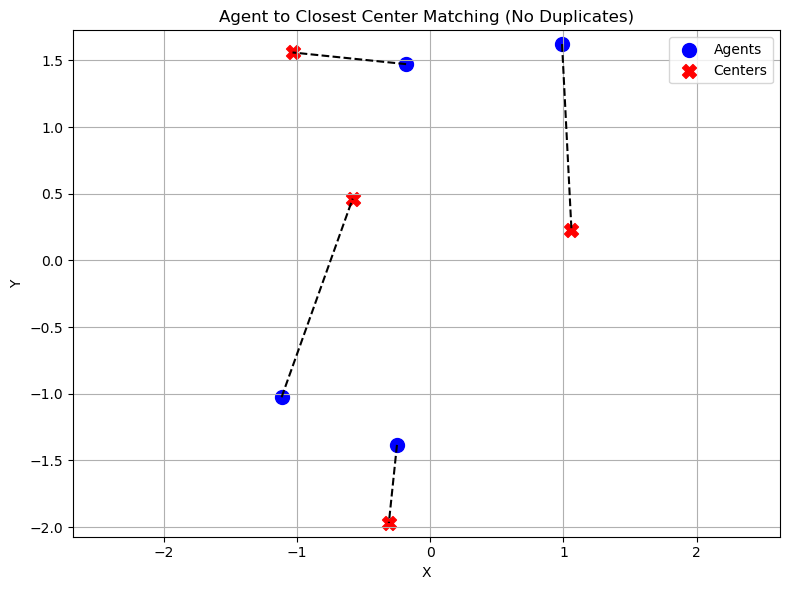

In [67]:
figure_closest_centers(agents_pos, centers, agent_indices, center_indices)

In [68]:
# tsp의 영역

In [69]:
print(agents_pos)
print(closest_clusters)
print(finished_pos)

[[-0.24875951 -1.3839879 ]
 [-0.17999411  1.47250199]
 [-1.11460066 -1.0266366 ]
 [ 0.98974705  1.62308931]]
[[<vmas.simulator.core.Landmark object at 0x76bca841f1f0>], [<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>], [<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>], [<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>]]
[[ 0.2  0.2]
 [ 0.2 -0.2]
 [-0.2 -0.2]
 [-0.2  0.2]]


In [70]:
print(closest_clusters[0])

temp = []
for target in closest_clusters[0]:
    x, y = target.state.pos.squeeze().tolist()
    temp.append([x, y])
# temp = np.array(temp)

print(temp)

[[-0.30958032608032227, -1.9697999954223633]]


In [71]:
def compute_euclidean_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if i != j:
                dx, dy = locations[i] - locations[j]
                matrix[i][j] = int(np.hypot(dx, dy) * 1000)  # 소수점 줄이기 위해 스케일 업
    return matrix

In [72]:
def dist_matrix(closest_clusters, agents_pos, finished_pos):
    agents_goals = []
    for i in range(len(closest_clusters)):
        agent_goal = [agents_pos[i].tolist(), finished_pos[i].tolist()]
        for target in closest_clusters[i]:
            x, y = target.state.pos.squeeze().tolist()
            agent_goal.append([x, y])
        agents_goals.append(agent_goal)  

    distance_matrix = []
    for locations in agents_goals:
        locations = np.array(locations)
        matrix = compute_euclidean_distance_matrix(locations)
        matrix = matrix.tolist()
        distance_matrix.append(matrix)
    
    return distance_matrix

In [73]:
distance_matrices = dist_matrix(closest_clusters, agents_pos, finished_pos)

In [74]:
def create_data_model(distance_matrix):
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1
    data["starts"] = [0]
    data["ends"] = [1]
    return data

def create_data_models(distance_matrices):
    data_matrix = []
    for distance_matrix in distance_matrices:
        data = create_data_model(distance_matrix)
        data_matrix.append(data)
    return data_matrix

In [75]:
data_matrix = create_data_models(distance_matrices)

In [76]:
def print_solution(data, manager, routing, solution):
    print(f"Objective: {solution.ObjectiveValue()}")
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        print(f"Route for vehicle {vehicle_id}: {route}")


In [77]:
def make_solutions(distance_matrices):
    """Entry point of the program."""
    # Instantiate the data problem.
    data_matrix = create_data_models(distance_matrices)
    
    solutions = []
    managers, routings = [], []

    for data in data_matrix:

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(data["distance_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        # Create and register a transit callback.
        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            # print(f"[DEBUG] from_node: {from_node}, to_node: {to_node}, matrix size: {len(data['distance_matrix'])}")
            if from_node >= len(data['distance_matrix']) or to_node >= len(data['distance_matrix']):
                print(f"[DEBUG] from_node: {from_node}, to_node: {to_node}, matrix size: {len(data['distance_matrix'])}")
            return data["distance_matrix"][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Add Distance constraint.
        dimension_name = "Distance"
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            10000,  # vehicle maximum travel distance
            True,  # start cumul to zero
            dimension_name,
        )
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        managers.append(manager)
        routings.append(routing)
        solutions.append(solution)
        
    return data_matrix, managers, routings, solutions

        # Print solution on console.
        # if solution:
        #     print_solution(data, manager, routing, solution)
        #     print("======================")

In [78]:
def get_routes(data, manager, routing, solution):
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))

    return route


In [79]:
data_matrix, managers, routings, solutions = make_solutions(distance_matrices)


routes = []
for i in range(len(solutions)):
    if solutions[i]:
        route = get_routes(data_matrix[i], managers[i], routings[i], solutions[i])
        routes.append(route[1:-1])

print(routes)
print(closest_clusters)

[[2], [2, 3], [2, 4, 3], [3, 5, 6, 4, 7, 2]]
[[<vmas.simulator.core.Landmark object at 0x76bca841f1f0>], [<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>], [<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>], [<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>]]


In [80]:
# routes에 따라 closest_clusters 재정렬
agents_goal = []

for cluster, route in zip(closest_clusters, routes):
    reordered = [cluster[i-2] for i in route]
    agents_goal.append(reordered)
    print(cluster)
print()
for agent_goal in agents_goal:
    print(agent_goal)
    
# 최종적인 결과물
# agents_goal. 

[<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>]
[<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>]
[<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>]

[<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841e170>]
[<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841f310>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>]
[<vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Lan

In [81]:
for i in range(len(solutions)):
    if solutions[i]:
        print_solution(data_matrix[i], managers[i], routings[i], solutions[i])
        print("======================")

Objective: 284416
Route for vehicle 0: [0, 2, 1]
Objective: 347339
Route for vehicle 0: [0, 2, 3, 1]
Objective: 316130
Route for vehicle 0: [0, 2, 4, 3, 1]
Objective: 445511
Route for vehicle 0: [0, 3, 5, 6, 4, 7, 2, 1]


In [82]:
# self.clusters = targets_clustering(self.world.agents, self.targets, self.finished_targets, cost_weight=0.15)
# self.agents_path, _ = open_tsp_assignment(self.world.agents, self.clusters, self.finished_targets)
# for route in self.agents_path:
#     for target in route:
#         target.state.pos = target.state.pos.to(self.device)

In [83]:
def kmeans_tsp(agents, targets, finished_position):
    agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)
    n_clusters = len(agents)
    
    labels, centers = kmeans_clust(targets_pos)
    clusters = zip_clusters(agents, targets, labels)
    
    agent_indices, center_indices, closest_clusters = closest_centers(agents_pos, centers, clusters)
    
    distance_matrices = dist_matrix(closest_clusters, agents_pos, finished_pos)
    data_matrix = create_data_models(distance_matrices)
    
    data_matrix, managers, routings, solutions = make_solutions(distance_matrices)
    
    routes = []
    for i in range(len(solutions)):
        if solutions[i]:
            route = get_routes(data_matrix[i], managers[i], routings[i], solutions[i])
            routes.append(route[1:-1])
            
    agents_goal = []

    for cluster, route in zip(closest_clusters, routes):
        reordered = [cluster[i-2] for i in route]
        agents_goal.append(reordered)
        
    return agents_goal
    


종합 테스트 필요  
1. 각 에이전트 별 거리(무게 포함)  
2. 전체 거리 합
3. 전체 거리 / 에이전트 수 = 평균
4. 평균과 각 에이전트 간의 거리 차이  
  
평균 차이가 적을 수록 성능 좋음.  
계산하는 데 걸리는 시간.  
클러스터링 후 랜더링  
후처리 기능 추가해야겠는걸..

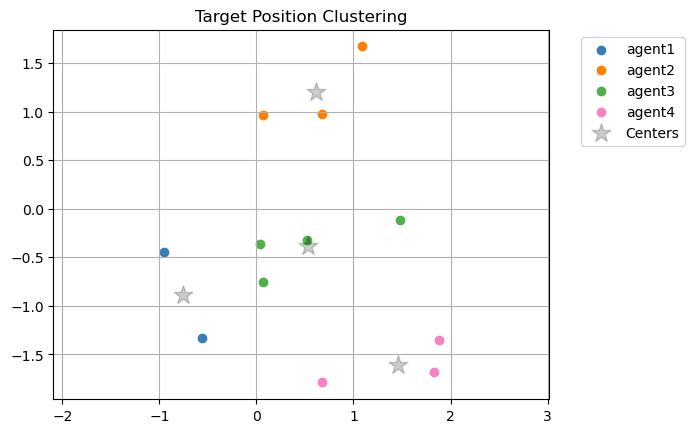

[[<vmas.simulator.core.Landmark object at 0x76bca841d8a0>, <vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841e170>], [<vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>], [<vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f340>], [<vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841f1f0>, <vmas.simulator.core.Landmark object at 0x76bca841f310>, <vmas.simulator.core.Landmark object at 0x76bca841e0e0>]]
[[2], [2, 3], [2, 4, 3], [3, 5, 6, 4, 7, 2]]


In [84]:
def kmeans_tsp_test(agents, targets, finished_position):
    agents, targets, finished_position= world_reset(env)

    agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)
    n_clusters = len(agents)

    labels, centers = kmeans_clust(targets_pos)
    clusters = zip_clusters(agents, targets, labels)

    agent_indices, center_indices, closest_clusters = closest_centers(agents_pos, centers, clusters)

    distance_matrices = dist_matrix(closest_clusters, agents_pos, finished_pos)
    data_matrix = create_data_models(distance_matrices)

    data_matrix, managers, routings, solutions = make_solutions(distance_matrices)

    routes = []
    for i in range(len(solutions)):
        if solutions[i]:
            route = get_routes(data_matrix[i], managers[i], routings[i], solutions[i])
            routes.append(route[1:-1])
            
    agents_goal = []

    for cluster, route in zip(closest_clusters, routes):
        reordered = [cluster[i-2] for i in route]
        agents_goal.append(reordered)
    
    return agents_goal, clusters, centers
    
agents_goal, clusters, centers = kmeans_tsp_test(agents, targets, finished_position)
clusters_render(agents, clusters, centers)

print(agents_goal)
print(routes)

# 거리와 무게 계산을 똑바로 해야만 한다이...
# 2가지 버전으로 나누어서 해결하는 게 좋을 듯

In [85]:
#######################################################################################
#######################################################################################
#######################################################################################
#######################################################################################
#######################################################################################


[1 0 2 3 2 0 3 2 1 3 1 0 3 1 2 0 3 3 2 1 2 0 0 1 0 2 3 0 3 1 3 2 2 0 3 3 2
 3 1 0 2 2 1 3 1 3 1 0 3 3 0 0 1 3 3 3 3 3 0 3 1 0 1 0 2 2 0 1 1 0 2 1 1 3
 0 3 3 3 1 1 0 2 1 3 0 2 1 3 3 1 3 2]


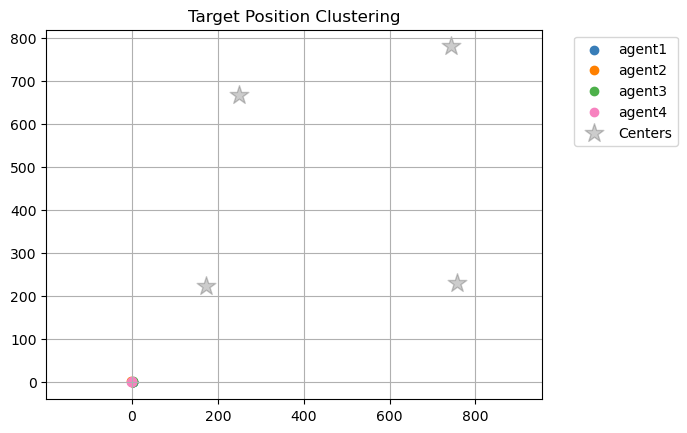

In [86]:
import random

def kmeans_tsp_test_11(agents, targets, finished_position):
    agents, targets, finished_position= world_reset(env)

    agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)
    n_clusters = len(agents)

    coords = [[random.randint(0, 1000), random.randint(0, 1000)] for _ in range(92)]
    coords = np.array(coords)
    
    labels, centers = kmeans_clust(coords)
    print(labels)
    # 삭제
    clusters = zip_clusters(agents, targets, labels)

    agent_indices, center_indices, closest_clusters = closest_centers(agents_pos, centers, clusters)

    distance_matrices = dist_matrix(closest_clusters, agents_pos, finished_pos)
    data_matrix = create_data_models(distance_matrices)

    data_matrix, managers, routings, solutions = make_solutions(distance_matrices)

    routes = []
    for i in range(len(solutions)):
        if solutions[i]:
            route = get_routes(data_matrix[i], managers[i], routings[i], solutions[i])
            routes.append(route[1:-1])
            
    agents_goal = []

    for cluster, route in zip(closest_clusters, routes):
        reordered = [cluster[i-2] for i in route]
        agents_goal.append(reordered)
    
    return agents_goal, clusters, centers
    
agents_goal, clusters, centers = kmeans_tsp_test_11(agents, targets, finished_position)
clusters_render(agents, clusters, centers)

# print(agents_goal)
# print(routes)

# 거리와 무게 계산을 똑바로 해야만 한다이...
# 2가지 버전으로 나누어서 해결하는 게 좋을 듯

In [87]:
def numpy_pos_for_test(agents, agents_goal, finished_position):
    agents_pos = []
    for agent in agents:
        x, y = agent.state.pos.squeeze().tolist()
        agents_pos.append([x, y])
    agents_pos = np.array(agents_pos)
    
    agents_goal_pos = []
    targets_cost_toal = []
    for agent_goal in agents_goal:
        targets_cost = []
        targets_pos = []
        for target in agent_goal:
            x, y = target.state.pos.squeeze().tolist()
            targets_pos.append([x, y])
            cost = target.cost.item()
            targets_cost.append(cost)
            
        targets_pos = np.array(targets_pos)
        targets_cost = np.array(targets_cost)
        agents_goal_pos.append(targets_pos)
        targets_cost_toal.append(targets_cost)
        

    finished_pos = []
    for pos in finished_position:
        x, y = pos.state.pos.squeeze().tolist()
        finished_pos.append([x, y])
    finished_pos = np.array(finished_pos)
    
    return agents_pos, agents_goal_pos, targets_cost_toal, finished_pos

In [88]:
agents_pos, agents_goal_pos, targets_cost_toal, finished_pos = numpy_pos_for_test(agents, agents_goal, finished_position)
print(agents_pos, agents_goal_pos, targets_cost_toal, finished_pos)

[[ 0.37585568 -1.0570786 ]
 [-1.86628175  0.65883493]
 [ 1.07263613  1.84068584]
 [-0.71574402  1.08811116]] [array([[ 1.28108311, -1.56706285],
       [ 1.48417902, -1.38104296],
       [ 1.5150497 , -0.7051549 ]]), array([[-1.35671902,  1.39872336],
       [ 0.96697044,  0.22066355],
       [ 0.72183037, -1.38201761]]), array([[ 1.60622597e-03,  5.48027992e-01],
       [-1.26425576e+00,  1.37516975e-01],
       [-1.16230631e+00, -1.79530311e+00]]), array([[ 1.91738343,  1.22742128],
       [ 1.85022616, -1.24002576],
       [ 0.98600125, -1.15322447]])] [array([20, 40, 10]), array([30, 10, 40]), array([20, 30, 40]), array([20, 30, 10])] [[ 0.2  0.2]
 [ 0.2 -0.2]
 [-0.2 -0.2]
 [-0.2  0.2]]


In [89]:
def calc_dist(agents_pos, agents_goal_pos, finished_pos):
    dist_tsp = []
    for i in range(len(agents_pos)):
        length = len(agents_goal_pos[i])
        start = np.array(agents_pos[i])
        end = np.array(agents_goal_pos[i][0])
        dist = np.linalg.norm(start - end)
        idx = 1
        while idx < length:
            start = end
            end = np.array(agents_goal_pos[i][idx])
            dist += np.linalg.norm(start-end)
            idx += 1
            
        start = end
        end = np.array(finished_pos[i])
        dist += np.linalg.norm(start - end)
        dist_tsp.append(dist)
    dist_tsp = np.array(dist_tsp)
    dist_sum = sum(dist_tsp)
    dist_avg = dist_sum/len(agents_pos)
    dist_diff = dist_tsp - dist_avg
    dist_diff_avg = sum(dist_diff) / 4
    
    return dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg

dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg = calc_dist(agents_pos, agents_goal_pos, finished_pos)

print(f"dist_tsp: {dist_tsp}")
print(f"dist_sum: {dist_sum}")
print(f"dist_avg: {dist_avg}")
print(f"dist_diff: {dist_diff}")
print(f"dist_diff_avg: {dist_diff_avg}")


dist_tsp: [3.58745641 6.41703846 6.80804778 7.77313703]
dist_sum: 24.58567968281168
dist_avg: 6.14641992070292
dist_diff: [-2.55896351  0.27061854  0.66162786  1.62671711]
dist_diff_avg: 6.661338147750939e-16


랜덤으로 정해주는 것과의 거리 차이

In [90]:
def random_choice(agents, targets):
    n_agents, n_targets = len(agents), len(targets)
    number= n_targets // n_agents
    
    return [targets[i:i+number] for i in range(0, n_targets, number)]

agents_goal = random_choice(agents, targets)
print(agents_goal)

[[<vmas.simulator.core.Landmark object at 0x76bca841e0e0>, <vmas.simulator.core.Landmark object at 0x76bca841ed10>, <vmas.simulator.core.Landmark object at 0x76bca841f0a0>], [<vmas.simulator.core.Landmark object at 0x76bca841e110>, <vmas.simulator.core.Landmark object at 0x76bca841e380>, <vmas.simulator.core.Landmark object at 0x76bca841d8a0>], [<vmas.simulator.core.Landmark object at 0x76bca841f340>, <vmas.simulator.core.Landmark object at 0x76bca841f1f0>, <vmas.simulator.core.Landmark object at 0x76bca841e170>], [<vmas.simulator.core.Landmark object at 0x76bca841eb60>, <vmas.simulator.core.Landmark object at 0x76bca841f310>, <vmas.simulator.core.Landmark object at 0x76bca841d9f0>]]


In [91]:
def random_render(agents, clusters, func= lambda target : target.state.pos.squeeze().tolist()):
    plt.Figure(figsize=(4, 4))
    for i, cluster in enumerate(clusters):
        for j, target in enumerate(cluster):
            x, y = func(target)
            plt.scatter(x, y, color = agents[i].color, label = f"agent{i+1}" if j == 0 else "")
            
    plt.title("Target Position Clustering")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    plt.grid(True)
    plt.axis('equal')
    plt.show()

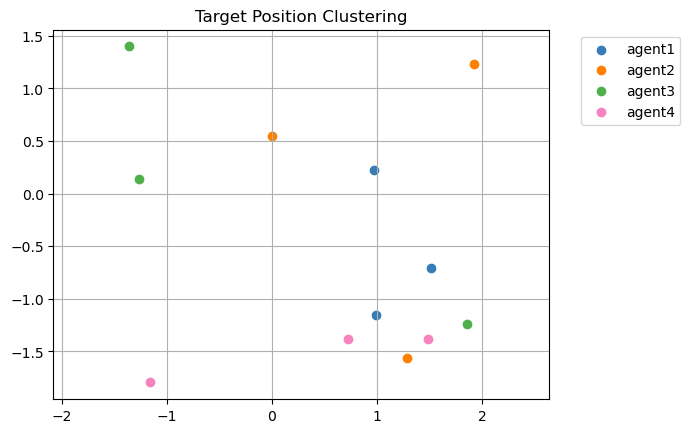

In [92]:
random_render(agents, agents_goal)
# 랜더링을 보고 싶으면 이 규격에 맞게 또 새로 만들어야 겠는걸....

agents_pos, agents_goal_pos, targets_cost_toal, finished_pos = numpy_pos_for_test(agents, agents_goal, finished_position)

In [93]:
dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg = calc_dist(agents_pos, agents_goal_pos, finished_pos)

print(f"dist_tsp: {dist_tsp}")
print(f"dist_sum: {dist_sum}")
print(f"dist_avg: {dist_avg}")
print(f"dist_diff: {dist_diff}")
print(f"dist_diff_avg: {dist_diff_avg}")

dist_tsp: [ 4.74196418  8.51273191 12.42352498  7.91908217]
dist_sum: 33.597303246567975
dist_avg: 8.399325811641994
dist_diff: [-3.65736163  0.1134061   4.02419916 -0.48024364]
dist_diff_avg: -6.661338147750939e-16


랜덤까지는 다 만들었음  
open m-tsp를 만들어야 함.  
m-tsp == vrp  
  
위에 있는 기존의 tsp가 멀티가 가능한 형태.  
데이터 셋 수정 + 멀티 설정 추가

In [94]:
def compute_euclidean_distance_matrix_for_mtsp(locations):
    n = len(locations)
    matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if i != j:
                dx, dy = locations[i] - locations[j]
                matrix[i][j] = int(np.hypot(dx, dy) * 1000)  # 소수점 줄이기 위해 스케일 업
    return matrix

In [95]:
# 기존 함수: 클러스터링에 맞게 매트릭스를 3차원으로 생성
# 수정 사항: 모든 타겟을 대상으로 검사. 이차원으로 생성
# : closest_clusters 필요 없음 -> targets_pos로 교체
def dist_matrix_for_mtsp(targets_pos, agents_pos, finished_pos):
    # 시작 지점 4개, 종료 지점 4개 추가 필요
    locations = np.vstack([agents_pos, finished_pos, targets_pos])

    matrix = compute_euclidean_distance_matrix(locations)
    
    return matrix

distance_matrix = dist_matrix_for_mtsp(targets_pos, agents_pos, finished_pos)

In [96]:
def create_data_model_for_mtsp(distance_matrix):
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 4
    data["starts"] = [0, 1, 2, 3]
    data["ends"] = [4, 5, 6, 7]
    return data

In [97]:
data_matrix = create_data_model_for_mtsp(distance_matrix)

In [98]:
def print_solution_for_mtsp(data, manager, routing, solution):
    dist_tsp = []
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance * 0.001}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        
        dist_tsp.append(route_distance * 0.001)
    print(f"Maximum of the route distances: {max_route_distance * 0.001}m")
    
    dist_sum = sum(dist_tsp)
    dist_avg = dist_sum / 4
    dist_diff = [dist - dist_avg for dist in dist_tsp]
    dist_diff_avg = sum(dist_diff) / 4
        
    return dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg


In [99]:
def make_solutions_for_mtsp(distance_matrix, max_dist):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model_for_mtsp(distance_matrix)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_dist,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    # if solution:
    #     dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg = print_solution_for_mtsp(data, manager, routing, solution)
    # else:
    #     print("impossible")
        
    return data, manager, routing, solution

        

In [100]:
data, manager, routing, solution = make_solutions_for_mtsp(distance_matrix, 10000)

if solution:
        dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg = print_solution_for_mtsp(data, manager, routing, solution)
else:
    print("impossible")

print(f"dist_tsp: {dist_tsp}")
print(f"dist_sum: {dist_sum}")
print(f"dist_avg: {dist_avg}")
print(f"dist_diff: {dist_diff}")
print(f"dist_diff_avg: {dist_diff_avg}")


Objective: 407894
Route for vehicle 0:
 0 ->  15 ->  19 ->  9 -> 4
Distance of the route: 3.903m

Route for vehicle 1:
 1 ->  8 -> 5
Distance of the route: 2.702m

Route for vehicle 2:
 2 ->  10 ->  12 ->  13 ->  11 -> 6
Distance of the route: 3.9410000000000003m

Route for vehicle 3:
 3 ->  14 ->  16 ->  18 ->  17 -> 7
Distance of the route: 3.248m

Maximum of the route distances: 3.9410000000000003m
dist_tsp: [3.903, 2.702, 3.9410000000000003, 3.248]
dist_sum: 13.794
dist_avg: 3.4485
dist_diff: [0.4544999999999999, -0.7465000000000002, 0.49250000000000016, -0.2004999999999999]
dist_diff_avg: 0.0


In [101]:
# 큰일남.
# 멀티 tsp가 성능이 너무 좋음
# 그냥 최강 빠름...
# 개수를 백단위로 늘려서 억지를 부려?

In [102]:
import random

coords = [[random.randint(0, 1000), random.randint(0, 1000)] for _ in range(100)]
coords = np.array(coords)
distance_matrix = compute_euclidean_distance_matrix_for_mtsp(coords)

data, manager, routing, solution = make_solutions_for_mtsp(distance_matrix, 100000000)

if solution:
        dist_tsp, dist_sum, dist_avg, dist_diff, dist_diff_avg = print_solution_for_mtsp(data, manager, routing, solution)
else:
    print("impossible")

Objective: 261720362
Route for vehicle 0:
 0 ->  62 ->  22 ->  16 ->  26 ->  21 ->  48 ->  39 ->  77 ->  47 ->  27 ->  55 ->  42 ->  40 ->  12 ->  50 ->  89 ->  98 ->  93 ->  60 ->  74 ->  56 ->  94 ->  71 ->  54 ->  37 -> 4
Distance of the route: 2516.797m

Route for vehicle 1:
 1 ->  17 ->  23 ->  90 ->  45 ->  80 ->  69 ->  88 ->  34 ->  81 ->  83 ->  53 ->  85 ->  91 ->  41 ->  44 ->  99 ->  43 ->  24 ->  76 ->  95 ->  97 ->  49 ->  10 ->  8 ->  82 ->  25 ->  75 -> 5
Distance of the route: 2500.242m

Route for vehicle 2:
 2 ->  51 ->  57 ->  30 ->  84 ->  19 ->  36 ->  67 ->  61 ->  86 ->  31 ->  9 ->  59 ->  66 ->  70 ->  14 ->  58 ->  72 ->  64 ->  28 ->  63 ->  20 ->  73 ->  15 ->  32 -> 6
Distance of the route: 2506.946m

Route for vehicle 3:
 3 ->  13 ->  65 ->  33 ->  79 ->  18 ->  11 ->  87 ->  52 ->  29 ->  68 ->  92 ->  38 ->  35 ->  78 ->  96 ->  46 -> 7
Distance of the route: 2516.677m

Maximum of the route distances: 2516.797m
